# S3E26: Multi-Class Prediction of Cirrhosis Outcomes

In this Playground competition, the goal is to predict Cirrhosis outcomes, based on a synthetic dataset.
We want to predict the `Status` of a patient after a certain number of days.
The status contains 3 classes: `C`, indicating the patient was alive, `CL`, indicating the patient was alive due to a liver transplant, and `D` indicating the patient was deceased.

## About This Notebook

The goal of this notebook is to be simple.
This notebook's focus is on data exploration and visualization, such that you don't have to do them yourself.
All plots are made by taking into account the feature type, with categorical and numerical plots.
The objective is to have a diverse look at the data.

At the end of this notebook, we train three popular Boosted Trees classifiers: XGBoost, LightGBM, and CatBoost.
These are the baseline models used for such tasks; you can either combine them as an ensemble or use them on their own.
This notebook strives to provide a solid foundation for future data exploration, pre-processing steps, and modeling.

**If you have any questions or feedback, feel free to use the comments.**

Good luck with this last Playground competition of the year!

# 0. Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

SEED = 42

# 1. Exploratory Data Analysis

## Data Exploration

In [3]:
train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")
sample = pd.read_csv("sample_submission.csv", index_col="id")

train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [4]:
train.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000
mean,2030.173308,18373.146490,2.594485,350.561923,3.548323,83.902846,1816.745250,114.604602,115.340164,265.228969,10.629462,3.032511
std,1094.233744,3679.958739,3.812960,195.379344,0.346171,75.899266,1903.750657,48.790945,52.530402,87.465579,0.781735,0.866511
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1230.000000,15574.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,211.000000,10.000000,2.000000
50%,1831.000000,18713.000000,1.100000,298.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,10.600000,3.000000
75%,2689.000000,20684.000000,3.000000,390.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


In [5]:
train.nunique()

N_Days           461
Drug               2
Age              391
Sex                2
Ascites            2
Hepatomegaly       2
Spiders            2
Edema              3
Bilirubin        111
Cholesterol      226
Albumin          160
Copper           171
Alk_Phos         364
SGOT             206
Tryglicerides    154
Platelets        227
Prothrombin       49
Stage              4
Status             3
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
 18  Status       

## First Look at The Data & Missing Values

We have a good balance between numerical features and categorical ones.
Luckily, we don't have any missing values in this dataset.

Let's proceed by creating two lists per feature type: one for categorical features, and one for numerical features.
These lists are used for plotting the data with their respective techniques.
Having a categorical features list is convenient for future processing steps, such as one-hot encoding of the classes.

In [8]:
target = "Status"

features = train.columns.drop(target)

cat_threshold = 5
train_nunique = train.drop(columns=target).nunique()

cat_features = train_nunique[train_nunique <= cat_threshold].index.tolist()
num_features = train_nunique[train_nunique > cat_threshold].index.tolist()

assert len(cat_features) + len(num_features) == len(features)

assert target not in features
assert target not in cat_features
assert target not in num_features

# 2. Plots

## Target: Count Plot

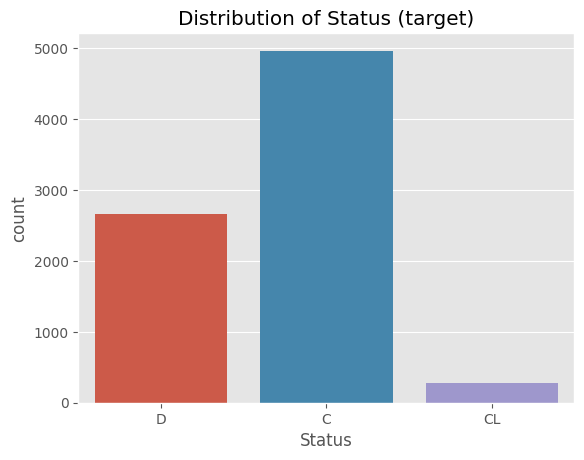

In [7]:
sns.countplot(data=train, x=target)
plt.title(f"Distribution of {target} (target)");

## Numerical Features Plots

We plot the numerical features using both a histogram plot and a boxplot.
Having the two views of the data allows to better understand the distribution.

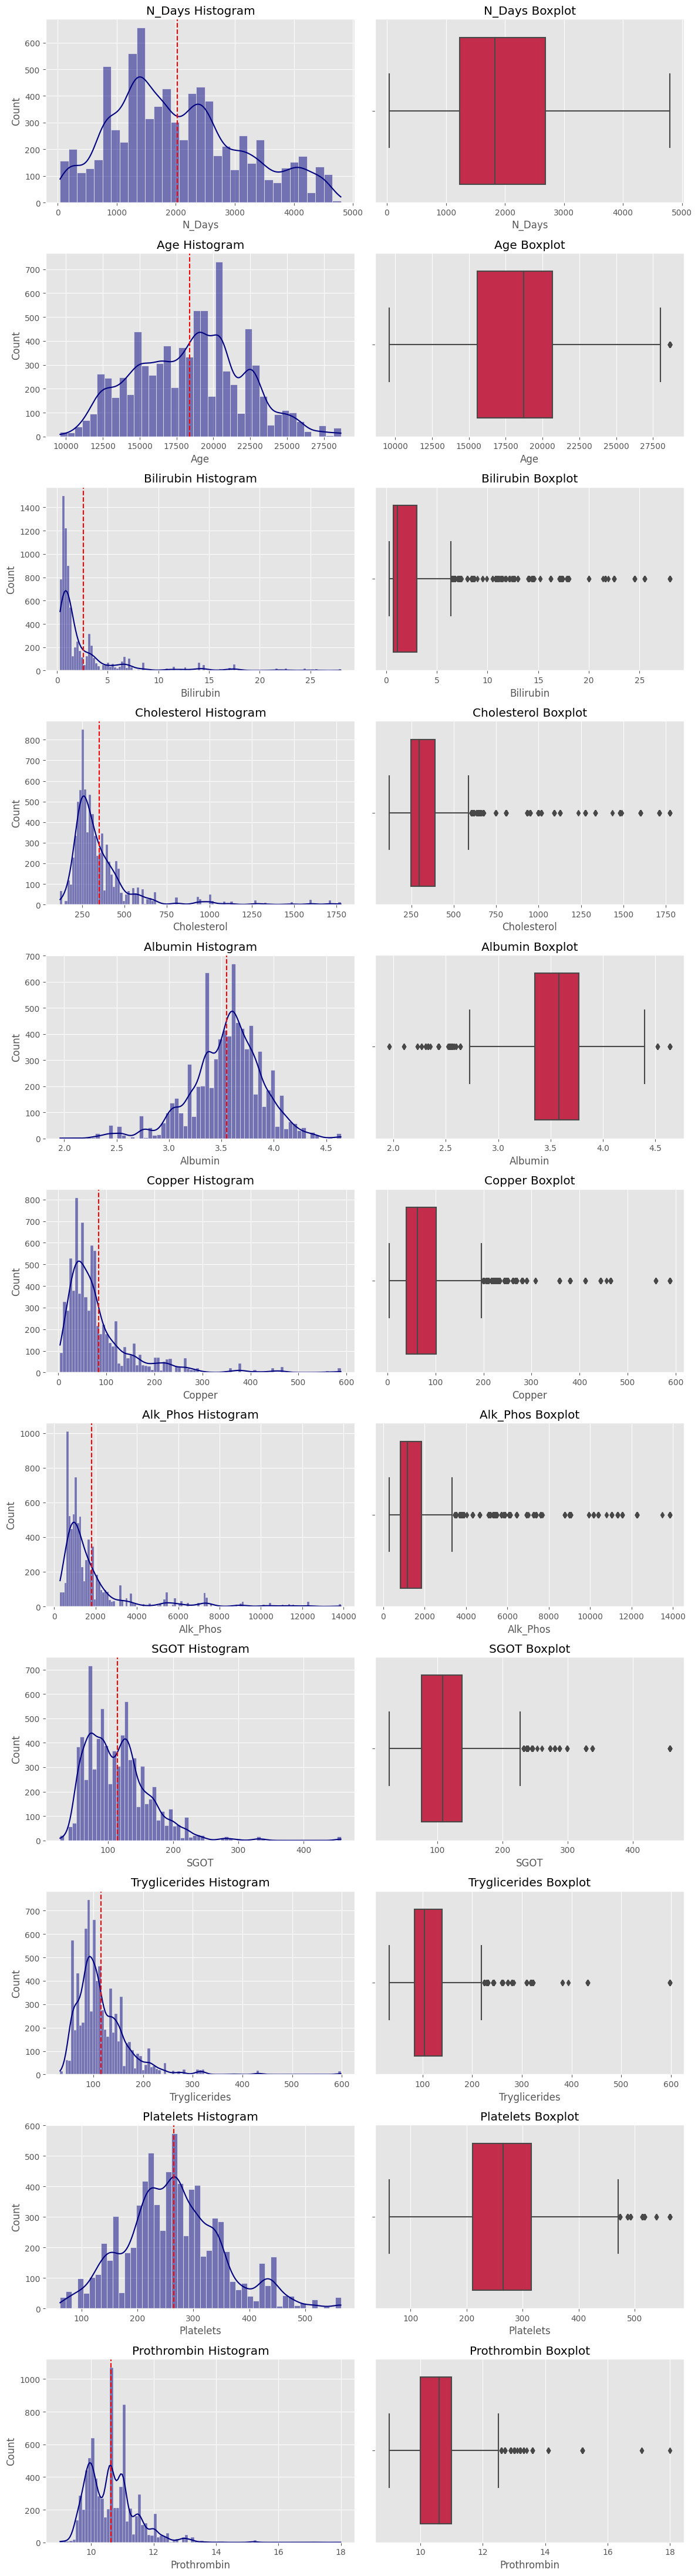

CPU times: user 6.52 s, sys: 4.04 s, total: 10.6 s
Wall time: 5.88 s


In [8]:
%%time
def num_features_plot(df: pd.DataFrame, features: list, nrows: int) -> None:
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 4 * nrows), layout="tight")

    for idx, feat in enumerate(features):
        sns.histplot(data=df, x=feat, kde=True, ax=axs[idx, 0], color="navy")
        axs[idx, 0].set_title(f"{feat} Histogram")
        axs[idx, 0].axvline(x=df[feat].mean(), color="red", linestyle="--")
        sns.boxplot(data=df, x=feat, ax=axs[idx, 1], color="crimson")
        axs[idx, 1].set_title(f"{feat} Boxplot")
    
    plt.show()
    
    
num_features_plot(train, num_features, len(num_features))

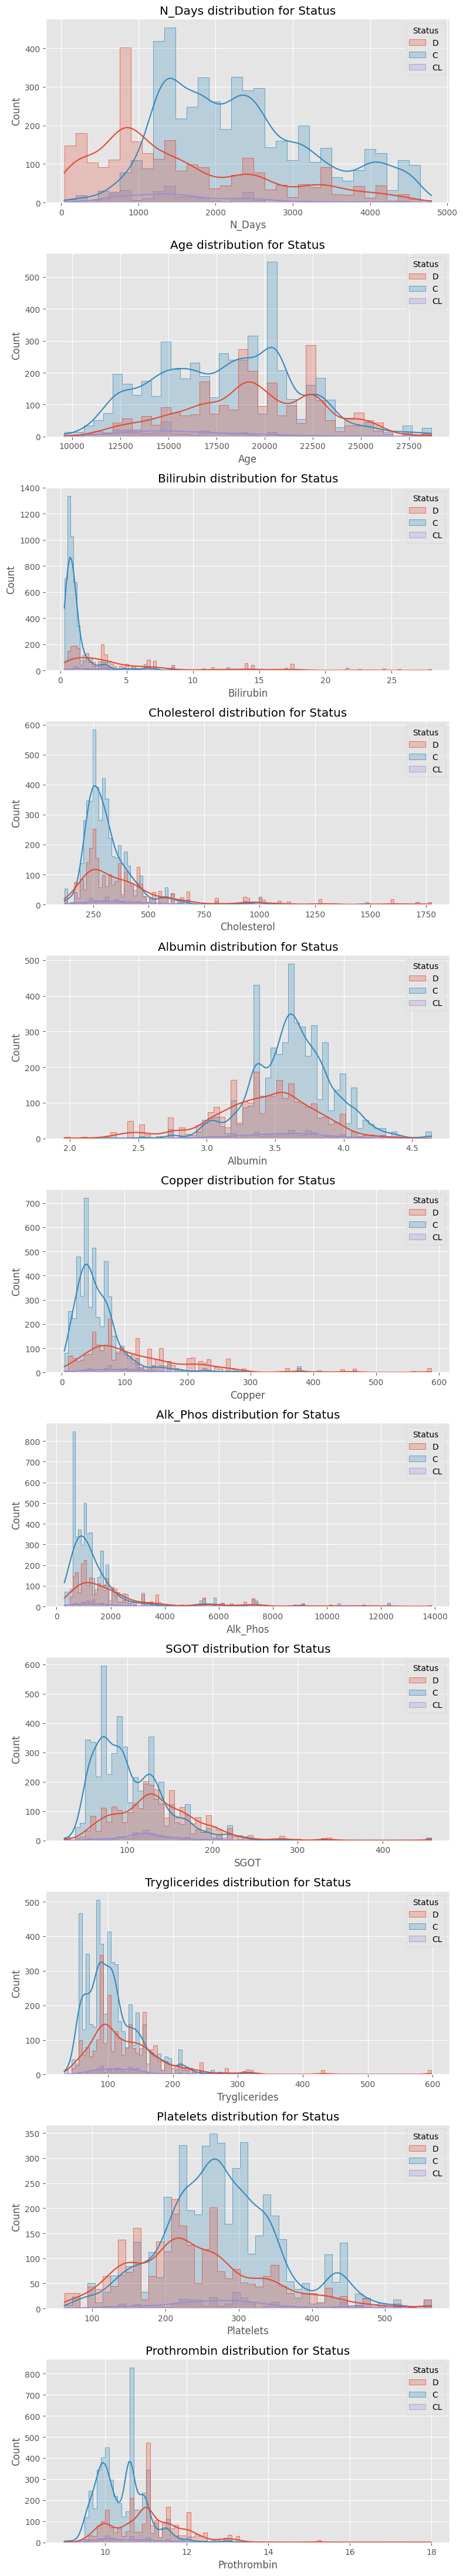

CPU times: user 4.34 s, sys: 3.32 s, total: 7.66 s
Wall time: 3.86 s


In [9]:
%%time
def num_features_target_plot(df: pd.DataFrame, features: list, target: str) -> None:
    nrows = len(num_features)
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(8, nrows * 4), layout="tight")
    
    for idx, feat in enumerate(features):
        sns.histplot(data=df, x=feat, hue=target, kde=True, element="step", ax=axs[idx])
        axs[idx].set_title(f"{feat} distribution for {target}")
        
    plt.show()
        
    
num_features_target_plot(train, num_features, target)

## Categorical Features Plots

Let's count the number of occurence of each class our target.
This way, we can study the categorical features and better understand their counts distribution.

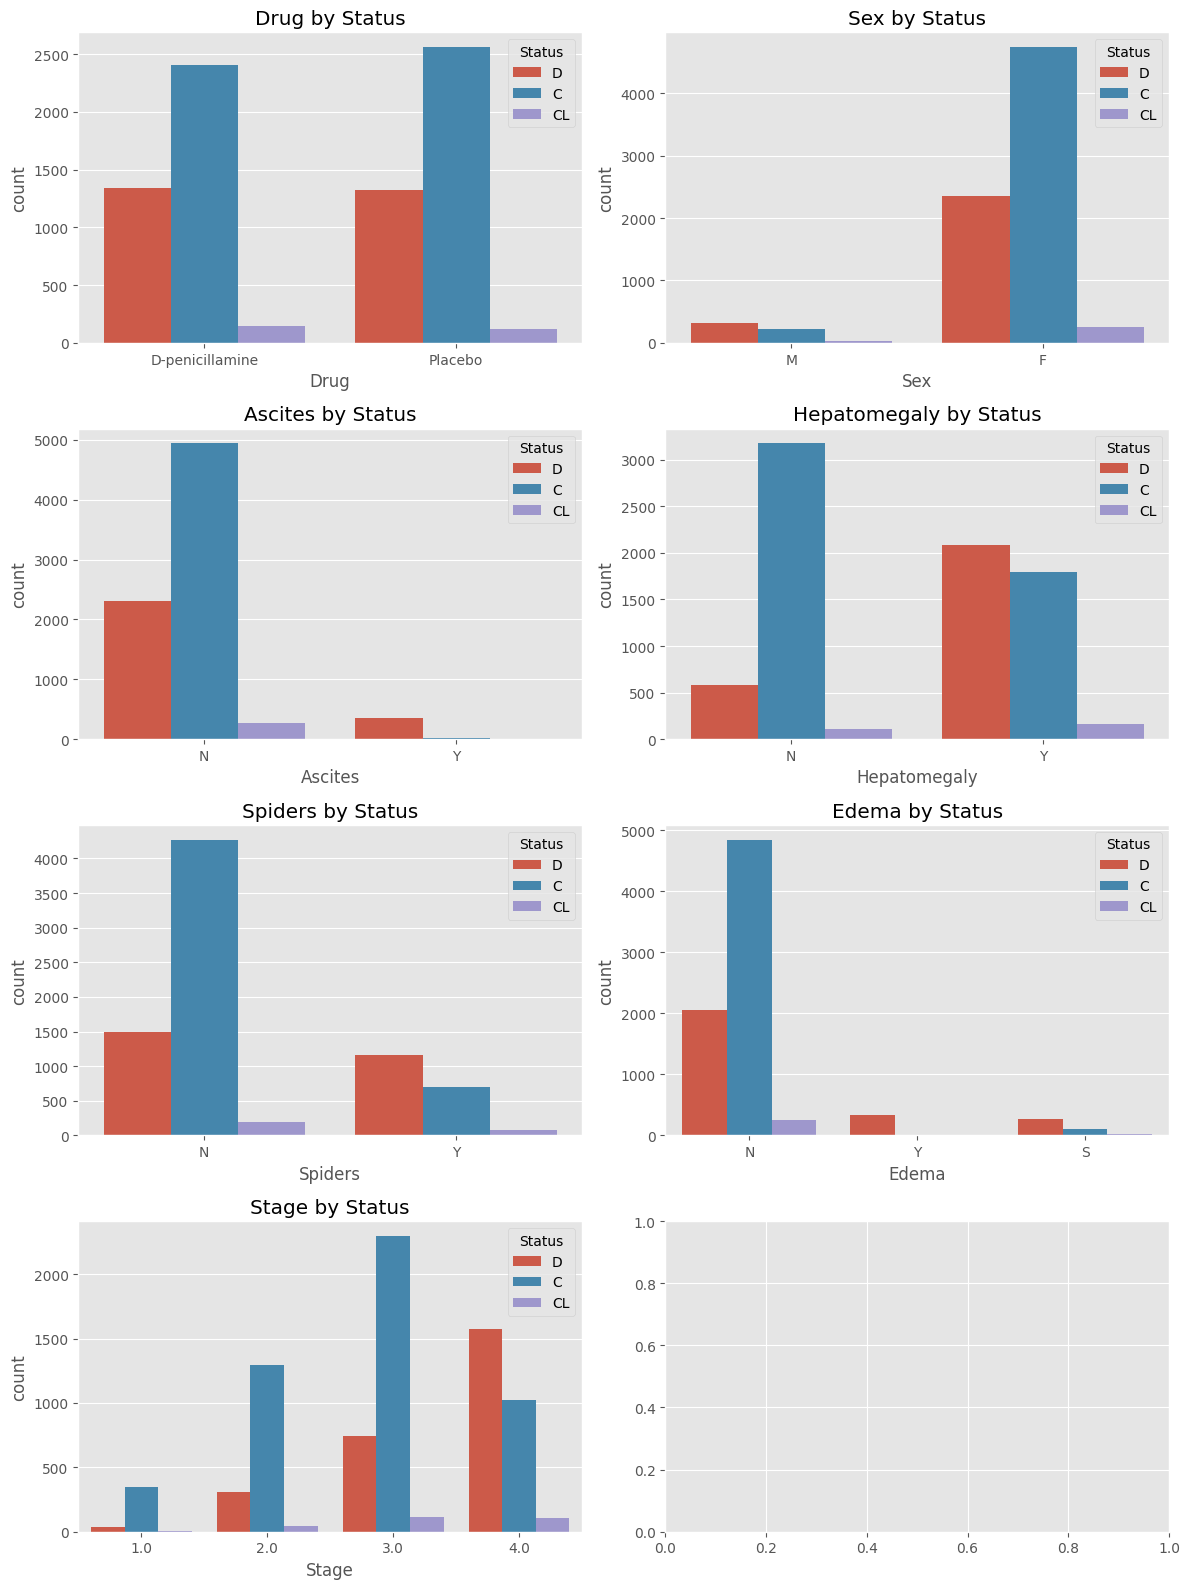

CPU times: user 1.65 s, sys: 276 ms, total: 1.92 s
Wall time: 1.62 s


In [10]:
%%time
def cat_features_plot(df: pd.DataFrame, cat_features: list, target: str, nrows: int):
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 4 * nrows), layout="tight")

    for idx, (feat, ax) in enumerate(zip(cat_features, axs.flat)):
        sns.countplot(data=train, x=feat, hue=target, ax=ax)
        ax.set_title(f"{feat} by {target}")

    plt.show()
        

nrows = np.ceil(len(cat_features) / 2).astype(int)
cat_features_plot(train, cat_features, target, nrows)

## Correlation Matrix

Correlation matrix is always useful to identify correlation between features.
Combined with feature importance per classifier, we can use this information to create new features.

CPU times: user 285 ms, sys: 205 ms, total: 491 ms
Wall time: 256 ms


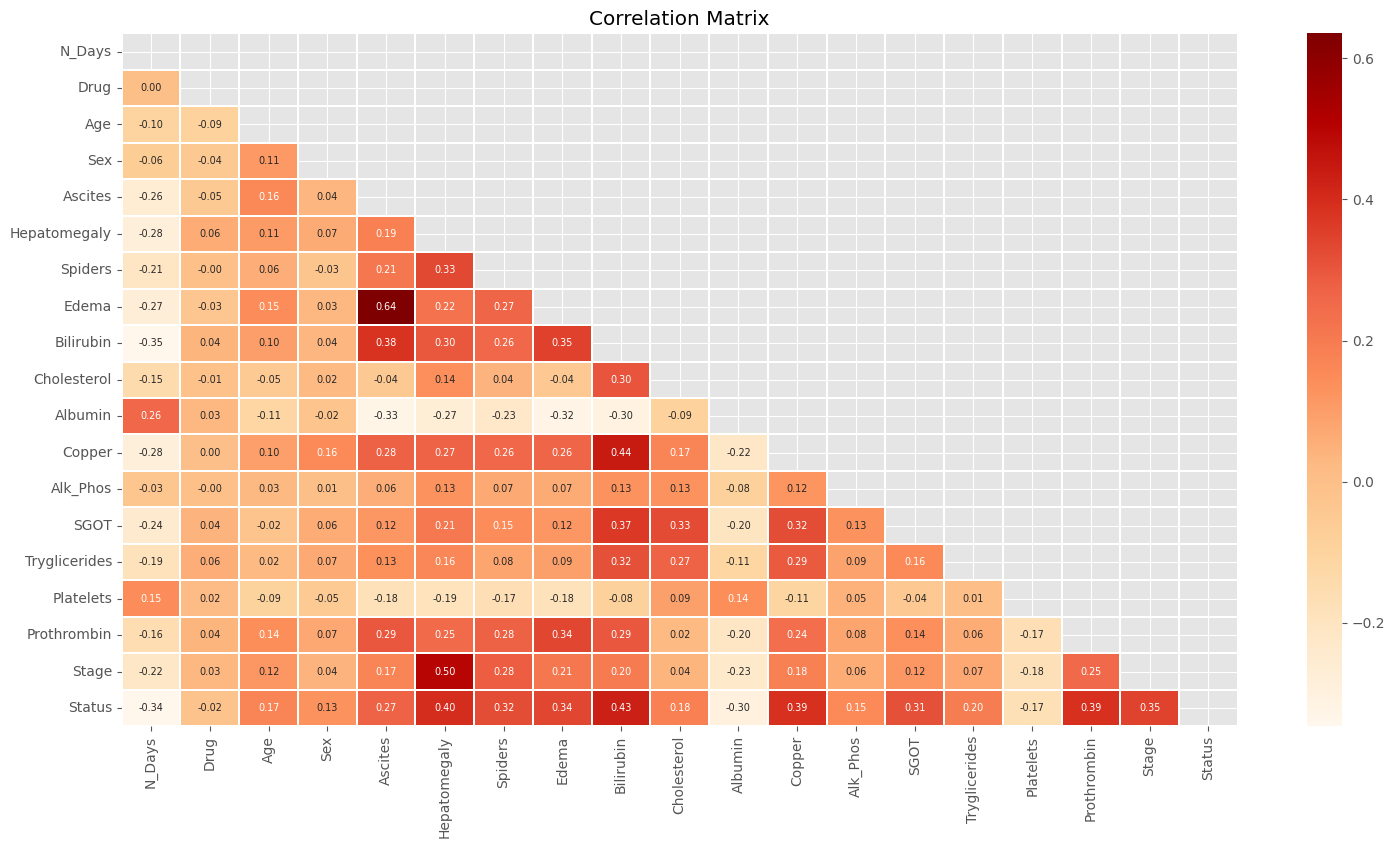

In [11]:
%%time
def plot_corr_heatmap(df: pd.DataFrame) -> None:
    corr= df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    plt.figure(figsize=(18, 9))
    sns.heatmap(corr, cmap="OrRd", annot=True, fmt=".2f", linewidths=.33, annot_kws={"fontsize": "x-small"}, mask=mask)
    plt.title("Correlation Matrix")
    

corr_train = train.copy()
# we must encode the categorical features for plotting
corr_train[cat_features + [target]] = corr_train[cat_features + [target]].apply(lambda x: x.astype('category').cat.codes)
  
plot_corr_heatmap(corr_train)

# 3. Feature Engineering

In this section, we manually combine existing features to create new ones. 
We use information from the plots, correlation matrix, and feature importance per model to select which features to use for feature engineering. 

# 4. Baseline Model

For the baseline models, we will be using Boosted Trees.
We want to compare which models performs the best on the dataset without data pre-processing.
Pre-processing will be left to the competitors to explore during the three weeks of competitions!
The competition's forum has some very good insights and discussions on how to extract and transform the data.  
You should consider tuning the model which performs the best to maximize performance even more.

In [9]:
from sklearn.preprocessing import LabelEncoder

X = train.drop(columns=[target])
y = train[target]

X = pd.get_dummies(X, columns=cat_features)

le = LabelEncoder().fit(y)
y = pd.Series(le.transform(y))

In [10]:
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

def evaluate_model(model, X: pd.DataFrame, y: pd.Series) -> list:
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
    val_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)

        val_score = log_loss(y_val, y_pred)

        print(f"###### FOLD {fold + 1} ######")
        print(f"log loss: {val_score:.4f}")

        val_scores.append(val_score)

    mean_score = np.mean(val_scores)
    score_std = np.std(val_scores)

    print("#####################")
    print(f"Mean log_loss: {mean_score:.4f} +/- {score_std:.4f}.")
    return val_scores

In [11]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
lgb_clf = LGBMClassifier()
cat_clf = CatBoostClassifier(logging_level='Silent')

models = [xgb_clf, lgb_clf, cat_clf]

val_scores = []

for model in models:
    print(f"\nModel name: {model}.")
    val_scores.append(evaluate_model(model, X, y))


Model name: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...).


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 1 ######
log loss: 0.5167


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 2 ######
log loss: 0.4999


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 3 ######
log loss: 0.5067


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 4 ######
log loss: 0.5360


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 5 ######
log loss: 0.4459


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 6 ######
log loss: 0.4787


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 7 ######
log loss: 0.5098


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 8 ######
log loss: 0.5380


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 9 ######
log loss: 0.5098


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 10 ######
log loss: 0.5361
#####################
Mean log_loss: 0.5078 +/- 0.0271.

Model name: LGBMClassifier().
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 28
[LightGBM] [Info] Start training from score -0.464900
[LightGBM] [Info] Start training from score -3.360432
[LightGBM] [Info] Start training from score -1.087430
###### FOLD 1 ######
log loss: 0.4568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1937
[LightGBM] [Info] Number of data points in the train set: 7114

Catboost seems to perform the best, followed by LightGBM. XGBoost comes last, with a log_loss 0.05 points higher than LightGBM.
Further experiments should be conducted to find which models performs the best.
Hyperparameters tuning should be performed as well, to improve performance even more.
XGBoost may perform better with a good set of hyperparameters, so we recommend you try tuning all three.

Based on the mean log loss obtained, CatBoost is the best classifier.

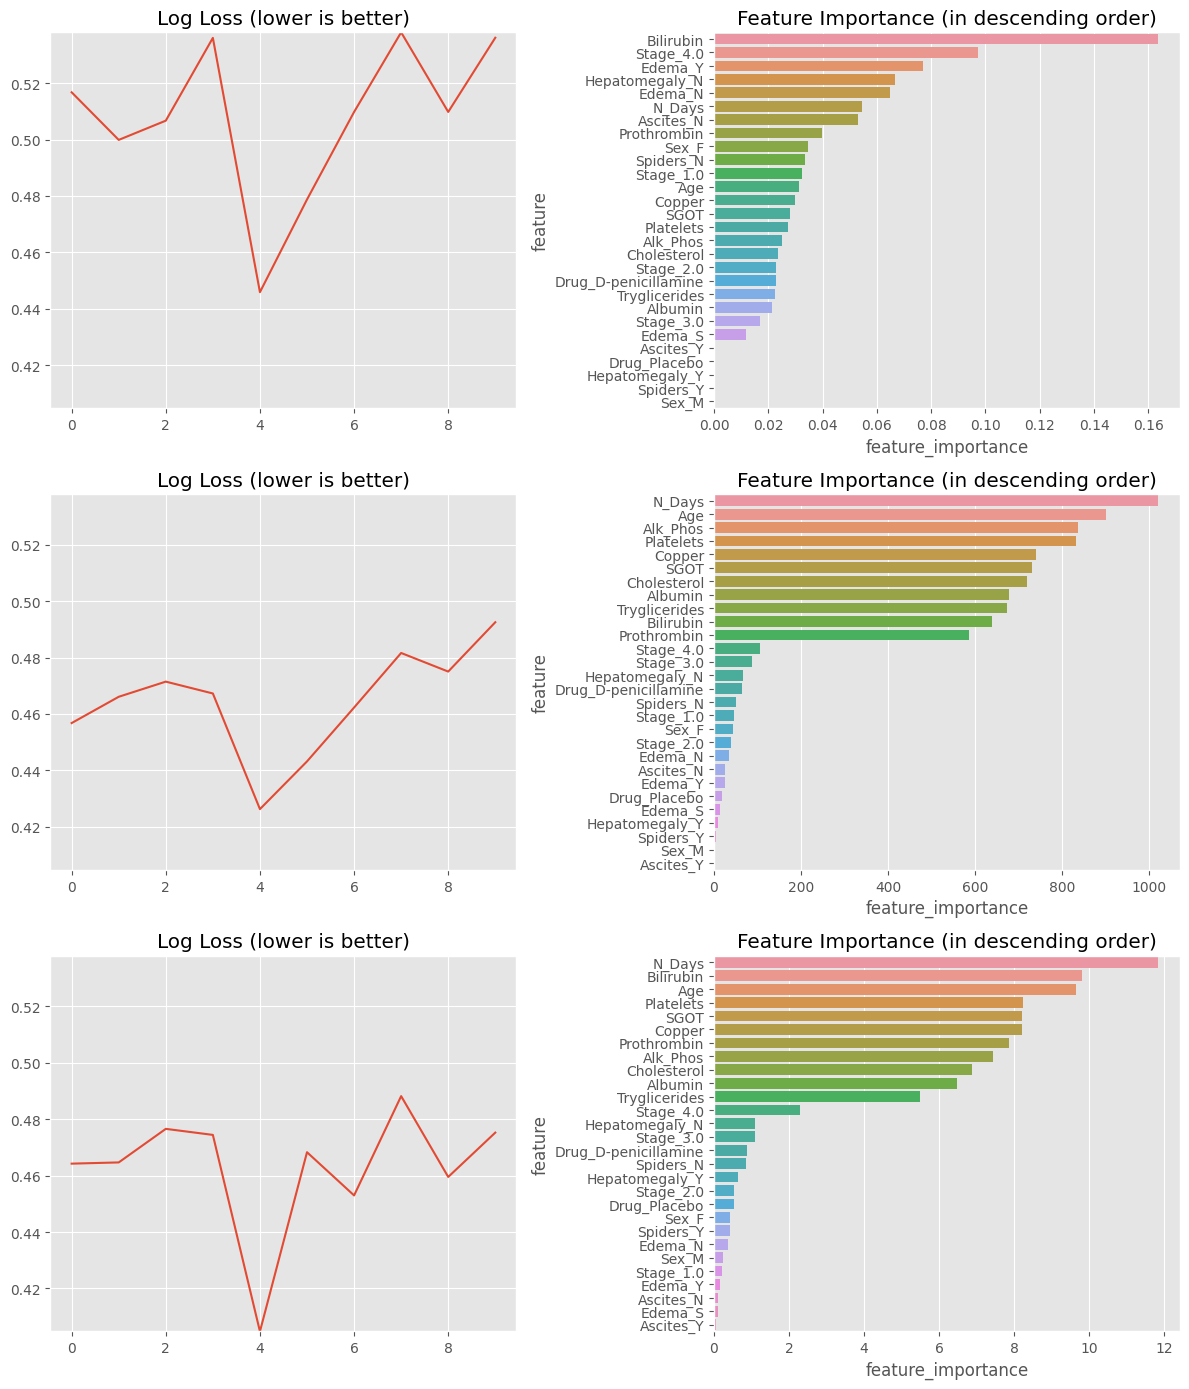

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 14), layout="tight")

y_min = np.min(val_scores)
y_max = np.max(val_scores)

for i, ax, in enumerate(axs):
    ax[0].plot(val_scores[i])
    ax[0].set_title("Log Loss (lower is better)")
    ax[0].set_ylim(y_min, y_max)

    feature_importances = models[i].feature_importances_

    importance_df = pd.DataFrame({"feature": X.columns, "feature_importance": feature_importances})
    importance_df.sort_values(by="feature_importance", ascending=False, inplace=True)

    sns.barplot(importance_df, y="feature", x="feature_importance", ax=ax[1])
    ax[1].set_title("Feature Importance (in descending order)")


plt.show()

## VotingClassifier: Combining All 3 Boosted Trees

In [12]:
from sklearn.ensemble import VotingClassifier

xgb_clf = XGBClassifier()
lgb_clf = LGBMClassifier()
cat_clf = CatBoostClassifier(logging_level='Silent')

eclf = VotingClassifier(
    estimators=[("xgb", xgb_clf), ("lgb", lgb_clf), ("cat", cat_clf)],
    voting="soft"
)

print(f"Model name: VotingClassifier w/ all 3 Gradient Boosting Techniques.")
val_scores.append(evaluate_model(eclf, X, y))

Model name: VotingClassifier w/ all 3 Gradient Boosting Techniques.


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 28
[LightGBM] [Info] Start training from score -0.464900
[LightGBM] [Info] Start training from score -3.360432
[LightGBM] [Info] Start training from score -1.087430


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 1 ######
log loss: 0.4602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1937
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 28
[LightGBM] [Info] Start training from score -0.464900
[LightGBM] [Info] Start training from score -3.360432
[LightGBM] [Info] Start training from score -1.087430


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 2 ######
log loss: 0.4597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1945
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 28
[LightGBM] [Info] Start training from score -0.464900
[LightGBM] [Info] Start training from score -3.360432
[LightGBM] [Info] Start training from score -1.087430


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 3 ######
log loss: 0.4686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1941
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 28
[LightGBM] [Info] Start training from score -0.464900
[LightGBM] [Info] Start training from score -3.360432
[LightGBM] [Info] Start training from score -1.087430


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 4 ######
log loss: 0.4724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1941
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 28
[LightGBM] [Info] Start training from score -0.464900
[LightGBM] [Info] Start training from score -3.360432
[LightGBM] [Info] Start training from score -1.087430


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 5 ######
log loss: 0.4105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1941
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 28
[LightGBM] [Info] Start training from score -0.465264
[LightGBM] [Info] Start training from score -3.356532
[LightGBM] [Info] Start training from score -1.087153


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 6 ######
log loss: 0.4471
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1940
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 28
[LightGBM] [Info] Start training from score -0.465264
[LightGBM] [Info] Start training from score -3.356532
[LightGBM] [Info] Start training from score -1.087153


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 7 ######
log loss: 0.4565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1944
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 28
[LightGBM] [Info] Start training from score -0.465264
[LightGBM] [Info] Start training from score -3.356532
[LightGBM] [Info] Start training from score -1.087153


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 8 ######
log loss: 0.4830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 28
[LightGBM] [Info] Start training from score -0.465264
[LightGBM] [Info] Start training from score -3.356532
[LightGBM] [Info] Start training from score -1.087153


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

###### FOLD 9 ######
log loss: 0.4619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1942
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 28
[LightGBM] [Info] Start training from score -0.465264
[LightGBM] [Info] Start training from score -3.356532
[LightGBM] [Info] Start training from score -1.087153
###### FOLD 10 ######
log loss: 0.4828
#####################
Mean log_loss: 0.4603 +/- 0.0198.


C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

A voting Classifier combining the three boosting techniques leads to a better log loss, even beating CatBoost by 0.0026 points.
Combining classifiers should be explored further and considered for the final submission.
We use this combination of classifier for this submission.

# 5. Hyperparameters Tuning

This section will be completed again in future version of this kernel. 
Catboost with hyperparameters tuning performed worse than the voting classifier.

We will attempt to tune all three models together in future versions.

# 6. Submission

In [13]:
y_test = test.copy()
y_test = pd.get_dummies(y_test, columns=cat_features)

predictions = eclf.predict_proba(y_test)

C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Ghost Codm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if 

In [14]:
submissions = pd.DataFrame({"id": test.index, "Status_C": predictions[:, 0], "Status_CL": predictions[:, 1], "Status_D": predictions[:, 2]})

submissions.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [19]:
!head submission.csv

id,Status_C,Status_CL,Status_D
7905,0.5067818411994608,0.013959876734503105,0.4792582637500255
7906,0.5385836209930707,0.20120434449072852,0.26021203451620084
7907,0.010652749713249391,0.0029851318606477634,0.986362115738849
7908,0.9626403037969592,0.002003940231715069,0.03535575119829745
7909,0.9137128783699162,0.028314275168298236,0.05797285142883929
7910,0.996643546482287,0.00026649334440049377,0.0030899401571529935
7911,0.9838916333280685,0.0014304726288406535,0.014677889488341372
7912,0.08170114970902081,0.0011206752713814147,0.9171781757956999
7913,0.0025850780948597127,0.0001481367841407705,0.9972667856194026
